In [2]:
pip install tensorflow

     -------------------------------------- 300.9/300.9 MB 3.4 MB/s eta 0:00:00
     -------------------------------------- 130.2/130.2 KB 7.5 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 2.3 MB/s eta 0:00:00
     -------------------------------------- 442.0/442.0 KB 1.6 MB/s eta 0:00:00
     -------------------------------------- 413.4/413.4 KB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 3.6 MB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 1.7 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 KB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 3.4 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 KB 3.0 MB/s eta 0:00:00
     -------------------------------------- 938.6/938.6 KB 5.9 MB/s eta 0:00:00
     ---------------------------------------- 1.

You should consider upgrading via the 'C:\Users\rubim\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
# Reading the data
df = pd.read_csv("C:\\archive (3)\\spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [11]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


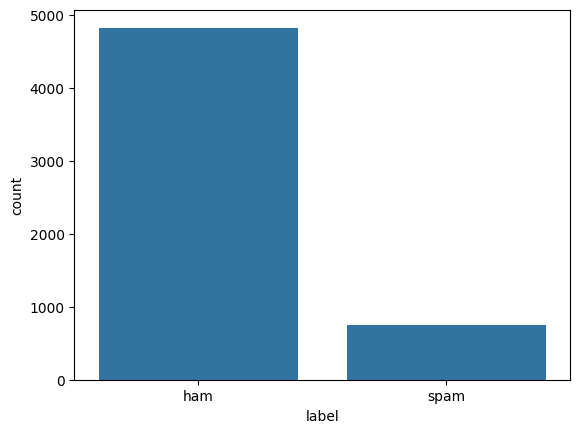

In [12]:
sns.countplot(x=df['label'])
plt.show()

In [13]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)

15


In [14]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)

15585


In [15]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split
 
X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
 
tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)
 
baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

In [17]:
from tensorflow.keras.layers import TextVectorization
 
MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len
 
text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)

In [18]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

In [19]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)
 
model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
    label_smoothing=0.5), metrics=['accuracy'])

In [20]:

from sklearn.metrics import precision_score, recall_score, f1_score
 
def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
 
def fit_model(model, epochs, X_train=X_train, y_train=y_train,
              X_test=X_test, y_test=y_test):
    '''
    fit the model with given epochs, train 
    and test data
    '''
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        validation_steps=int(0.2*len(X_test)))
    return history
 
def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy, 
    precision, recall and f1-score 
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)
 
    model_results_dict = {'accuracy': accuracy,
                          'precision': precision,
                          'recall': recall,
                          'f1-score': f1}
 
    return model_results_dict

In [21]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
    64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)
 
compile_model(model_2)  # compile the model
history_2 = fit_model(model_2, epochs=5)  # fit the model

Epoch 1/5

140/140 [==============================] - 24s 97ms/step - loss: 0.1580 - accuracy: 0.9457 - val_loss: 0.0808 - val_accuracy: 0.9785
Epoch 2/5
140/140 [==============================] - 11s 82ms/step - loss: 0.0277 - accuracy: 0.9933 - val_loss: 0.0988 - val_accuracy: 0.9776
Epoch 3/5
140/140 [==============================] - 11s 80ms/step - loss: 0.0058 - accuracy: 0.9984 - val_loss: 0.1159 - val_accuracy: 0.9758
Epoch 4/5
140/140 [==============================] - 11s 79ms/step - loss: 0.0032 - accuracy: 0.9987 - val_loss: 0.1428 - val_accuracy: 0.9686
Epoch 5/5
140/140 [==============================] - 11s 80ms/step - loss: 5.8086e-04 - accuracy: 0.9998 - val_loss: 0.1548 - val_accuracy: 0.9767


In [23]:
pip install tensorflow_hub

     -------------------------------------- 85.4/85.4 KB 799.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\rubim\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [24]:

import tensorflow_hub as hub
 
# model with Sequential api
model_3 = keras.Sequential()
 
# universal-sentence-encoder layer 
# directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           input_shape=[],
                           dtype=tf.string,
                           name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))
 
compile_model(model_3)
 
history_3 = fit_model(model_3, epochs=5)

Epoch 1/5
140/140 [==============================] - 8s 27ms/step - loss: 0.3159 - accuracy: 0.9062 - val_loss: 0.1184 - val_accuracy: 0.9686
Epoch 2/5
140/140 [==============================] - 3s 18ms/step - loss: 0.0827 - accuracy: 0.9791 - val_loss: 0.0726 - val_accuracy: 0.9758
Epoch 3/5
140/140 [==============================] - 3s 19ms/step - loss: 0.0590 - accuracy: 0.9816 - val_loss: 0.0589 - val_accuracy: 0.9812
Epoch 4/5
140/140 [==============================] - 3s 19ms/step - loss: 0.0467 - accuracy: 0.9863 - val_loss: 0.0528 - val_accuracy: 0.9821
Epoch 5/5
140/140 [==============================] - 3s 18ms/step - loss: 0.0392 - accuracy: 0.9872 - val_loss: 0.0524 - val_accuracy: 0.9830


In [25]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)
 
total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
                             'Custom-Vec-Embedding Model':model_1_results,
                             'Bidirectional-LSTM Model':model_2_results,
                             'USE-Transfer learning Model':model_3_results}).transpose()
 
total_results

35/35 [==============================] - 1s 12ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.754260,0.092105,0.093333,0.092715
Bidirectional-LSTM Model,0.976682,0.955882,0.866667,0.909091
USE-Transfer learning Model,0.982960,0.971223,0.900000,0.934256
